### Import Library
Mengimpor seluruh library yang dibutuhkan untuk pemrosesan gambar, pembuatan model, pelatihan, evaluasi, dan visualisasi.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
import time
from collections import Counter
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
import os
import random
from glob import glob
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Mount Google Drive
Untuk mengakses dataset yang disimpan di Google Drive.

In [ ]:
drive.mount('/content/drive')  # Mount Google Drive ke path /content/drive

Mounted at /content/drive


### Menyalin Dataset ke Workspace
Menyalin dataset dari Google Drive ke direktori lokal Colab agar proses training lebih cepat.

In [ ]:
!cp -r /content/drive/MyDrive/TA/Dataset\ Final /content/dataset_final


### Memuat Dataset sebagai TensorFlow Dataset dan  Menghitung Jumlah Gambar per Kelas

- Menggunakan image_dataset_from_directory untuk memuat dataset terstruktur dalam folder (setiap subfolder dianggap sebagai label/kategori).

- Menggunakan Counter untuk mengetahui distribusi gambar dalam tiap kelas.


In [ ]:
data_dir = '/content/dataset_final'  # Path folder dataset

data = tf.keras.utils.image_dataset_from_directory(
    data_dir,                        # Path ke direktori dataset
    image_size=(224, 224),          # Ukuran gambar yang di-resize
    batch_size=8,                   # Jumlah gambar dalam satu batch
    shuffle=True                    # Data diacak
)

class_names = data.class_names      # Mendapatkan nama-nama kelas
print("Class names:", class_names)  # Menampilkan nama kelas

label_counts = Counter()            # Untuk menghitung jumlah gambar per kelas

for images, labels in data:
    for label in labels.numpy():    # Mengonversi label dari tensor ke nilai numerik
        class_name = class_names[label]  # Mengambil nama kelas dari label numerik
        label_counts[class_name] += 1    # Menambahkan jumlah per kelas

# Menampilkan hasil
print("\nJumlah gambar per kelas:")
total = 0
for class_name in class_names:
    count = label_counts[class_name]
    print(f"{class_name}: {count}")
    total += count

print(f"\nTotal semua gambar: {total}")


Found 17600 files belonging to 4 classes.
Class names: ['Kaca', 'Kardus', 'Logam', 'Plastik']

Jumlah gambar per kelas:
Kaca: 4400
Kardus: 4400
Logam: 4400
Plastik: 4400

Total semua gambar: 17600


### Menampilkan Sampel Gambar dari Setiap Kelas

Untuk memverifikasi isi dan kualitas dataset secara visual.

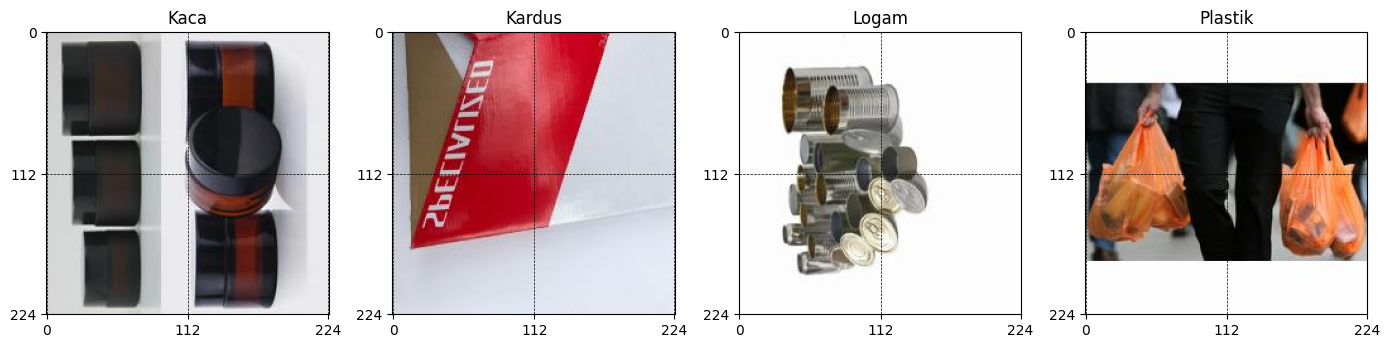

In [ ]:
plt.figure(figsize=(14, 6))  # Ukuran kanvas gambar 14x6 inci

for i, class_name in enumerate(class_names):  # Loop tiap kelas
    class_folder = os.path.join(data_dir, class_name)  # Path folder tiap kelas
    img_files = glob(os.path.join(class_folder, '*.jpg')) + \
                glob(os.path.join(class_folder, '*.jpeg')) + \
                glob(os.path.join(class_folder, '*.png'))  # Ambil semua file gambar

    if not img_files:
        continue

    img_path = random.choice(img_files)  # Pilih satu gambar secara acak
    img = cv2.imread(img_path)           # Baca gambar dengan OpenCV (format BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB

    plt.subplot(1, len(class_names), i + 1)  # Buat subplot
    plt.imshow(img)
    plt.title(class_name)  # Judul = nama kelas
    plt.xticks([0, img.shape[1]//2, img.shape[1]-1], labels=[0, img.shape[1]//2, img.shape[1]], color='black')
    plt.yticks([0, img.shape[0]//2, img.shape[0]-1], labels=[0, img.shape[0]//2, img.shape[0]], color='black')
    plt.grid(visible=True, color='black', linestyle='--', linewidth=0.5)  # Tampilkan grid
    plt.gca().spines['top'].set_color('black')   # Warna garis tepi
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['right'].set_color('black')

plt.tight_layout()
plt.show()

### Normalisasi Gambar (Rescaling 0-1)
Mengubah nilai piksel dari rentang 0-255 ke 0-1 agar model dapat memproses lebih stabil.

In [ ]:
for images, labels in data.take(1):  # Ambil satu batch
    print(f"Original pixel range: min={tf.reduce_min(images).numpy()}, max={tf.reduce_max(images).numpy()}")
    original_images = images.numpy().astype("uint8")  # Konversi ke uint8

# Fungsi normalisasi
def process_images(images, labels):  # Fungsi normalisasi
    images = tf.cast(images, tf.float32) / 255.0  # Bagi nilai piksel dengan 255
    return images, labels

data = data.map(process_images)  # Terapkan normalisasi ke semua batch

for images, labels in data.take(1):
    print(f"Normalized pixel range: min={tf.reduce_min(images).numpy()}, max={tf.reduce_max(images).numpy()}")

# Tampilkan ukuran gambar
print(f"Image shape: {images[0].shape}")

Original pixel range: min=0.0, max=255.0
Normalized pixel range: min=0.0, max=1.0
Image shape: (224, 224, 3)


### Membagi Dataset (Train, Validation, Test)
Dataset dibagi menjadi 80% training, 10% validation, dan 10% test.

- Train, digunakan untuk melatih model agar mengenali pola dalam data
- Validation, digunakan untuk mengevaluasi performa model selama pelatihan
- Test, digunakan untuk menguji model setelah pelatihan

In [ ]:
total_batches = tf.data.experimental.cardinality(data).numpy()  # Total batch
train_size = int(0.8 * total_batches)  # 80% untuk pelatihan
val_size = int(0.1 * total_batches)    # 10% untuk validasi

train_data = data.take(train_size)
val_test_data = data.skip(train_size)
val_data = val_test_data.take(val_size)
test_data = val_test_data.skip(val_size)

### Optimisasi Pipeline Dataset
Menggunakan shuffle() dan prefetch() untuk efisiensi pelatihan.

In [ ]:
train_data = train_data.shuffle(100).prefetch(1)  # Acak & prefetch batch untuk training
val_data = val_data.prefetch(1)                   # Prefetch batch validasi
test_data = test_data.prefetch(1)                 # Prefetch batch uji

### Load Model Pre-trained MobileNetV2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),    # Ukuran input gambar
    include_top=False,            # Tidak menyertakan output layer default
    weights='imagenet'            # Menggunakan bobot dari ImageNet
)
base_model.trainable = False     # Layer MobileNetV2 dibekukan

model = tf.keras.Sequential([
    base_model,                              # Feature extractor
    tf.keras.layers.GlobalAveragePooling2D(),# Mengubah feature map jadi vektor
    tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer
    tf.keras.layers.Dropout(0.3),            # Dropout untuk regularisasi
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Output layer
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Loss untuk label numerik (bukan one-hot)
    metrics=['accuracy']
)
model.summary()  # Struktur model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Menambahkan Callbacks
- EarlyStopping: Menghentikan pelatihan jika validasi tidak membaik.

- ReduceLROnPlateau: Mengurangi learning rate jika model stagnan.

In [ ]:
# Callbacks
from tensorflow.keras import layers, models, callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)  # Stop jika val loss tak membaik 5 epoch
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)   # Kurangi LR jika stagnan 3 epoch

### Melatih Model
Melatih model dan mengukur waktu pelatihan.

In [ ]:
import time
start_time = time.time() # Mulai hitung waktu

# Training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # Bisa disesuaikan, EarlyStopping akan menghentikan lebih awal jika perlu
    callbacks=[early_stop, reduce_lr]
)

end_time = time.time() # Catat waktu selesai
elapsed_time = end_time - start_time # Hitung total waktu pelatihan

print(f"Training time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

Epoch 1/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.7950 - loss: 0.5336 - val_accuracy: 0.9216 - val_loss: 0.2284 - learning_rate: 0.0010
Epoch 2/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9157 - loss: 0.2329 - val_accuracy: 0.9330 - val_loss: 0.1721 - learning_rate: 0.0010
Epoch 3/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9373 - loss: 0.1694 - val_accuracy: 0.9392 - val_loss: 0.1797 - learning_rate: 0.0010
Epoch 4/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - accuracy: 0.9482 - loss: 0.1400 - val_accuracy: 0.9347 - val_loss: 0.2167 - learning_rate: 0.0010
Epoch 5/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9598 - loss: 0.1039 - val_accuracy: 0.9551 - val_loss: 0.1242 - learning_rate: 0.0010
Epoch 6/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9675 - loss: 0.0868 - val_accuracy: 0.9602 - val_loss: 0.1390 - learning_rate: 0.0010
Epoch 7/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accura

###  Visualisasi Akurasi dan Loss
Grafik ini menunjukkan perkembangan kinerja model selama pelatihan.

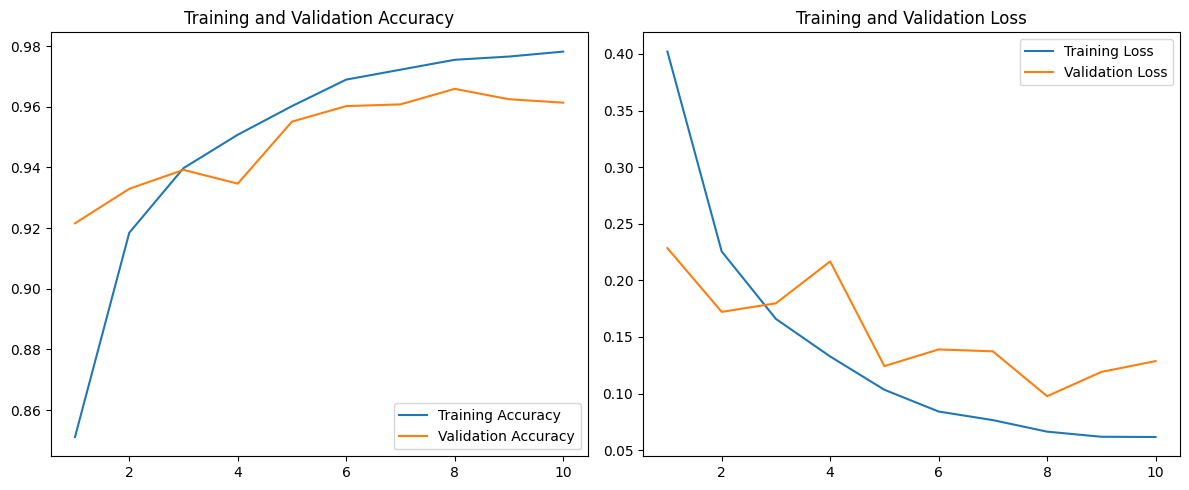

In [ ]:
epochs_range = range(1, len(history.history['accuracy']) + 1) # Range sesuai jumlah epoch

plt.figure(figsize=(12, 5))  # Ukuran kanvas
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

### Evaluasi Model dengan Confusion Matrix dan Classification Report
Mengetahui presisi, recall, dan f1-score dari model pada data uji.

In [ ]:
y_true = [] # Label asli
y_pred = [] # Hasil prediksi

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy()) # Simpan label asli
    y_pred.extend(np.argmax(preds, axis=1)) # Ambil prediksi label dengan nilai tertinggi

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━

### Import Library
Mengimpor seluruh library yang dibutuhkan untuk pemrosesan gambar, pembuatan model, pelatihan, evaluasi, dan visualisasi.

=== Classification Report ===
              precision    recall  f1-score   support

        Kaca       0.93      0.97      0.95       423
      Kardus       0.99      0.97      0.98       458
       Logam       0.97      0.95      0.96       429
     Plastik       0.94      0.93      0.94       450

    accuracy                           0.96      1760
   macro avg       0.96      0.96      0.96      1760
weighted avg       0.96      0.96      0.96      1760



<Figure size 1000x800 with 0 Axes>

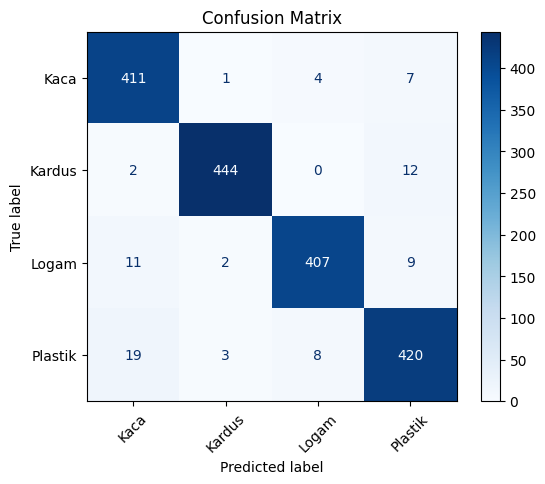

In [ ]:
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred) # Matriks kebingungan
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

### Prediksi dan Visualisasi pada Sampel Data Uji
Menampilkan 8 sampel gambar dari data uji beserta label asli dan hasil prediksi.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


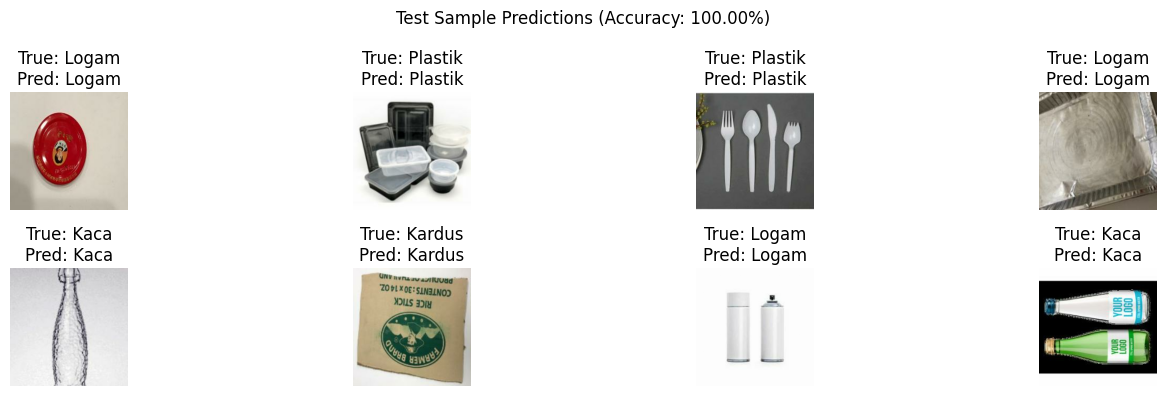

In [ ]:
def test_and_visualize(model, test_data, class_names):
    for images, labels in test_data.take(1):  # Ambil 1 batch dari test set
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)  # Ambil prediksi label
        acc = np.mean(pred_labels == labels.numpy()) * 100  # Hitung akurasi

        plt.figure(figsize=(15, 4))
        for i in range(min(8, len(images))):  # Maksimum 8 gambar ditampilkan
            plt.subplot(2, 4, i+1)
            plt.imshow(images[i].numpy())
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
            plt.axis("off")
        plt.suptitle(f"Test Sample Predictions (Accuracy: {acc:.2f}%)")
        plt.tight_layout()
        plt.show()
        break

# Panggil fungsi
test_and_visualize(model, test_data, class_names)